In [1]:
import os
import numpy as np
import csv
import re

In [24]:
#
def input_x(filename):
    x_data = []
    with open(filename, 'r', encoding="utf-8") as file:
        reader = csv.reader(file)
        next(reader)
        for row in reader:
            x_data.append(row[1:4])
    return x_data
#
def input_y(filename):
    y_data = []
    with open(filename, 'r', encoding="utf-8") as file:
        reader = csv.reader(file)
        next(reader)
        for row in reader:
            y_data.append(int(row[4]))
    return y_data

In [25]:
x_train_data = input_x("train.csv")
y_label = input_y("train.csv")
print(x_train_data[:5])
print(y_label[:5])
print(len(x_train_data))
print(len(y_label))

[['', '', 'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'], ['', '', 'Forest fire near La Ronge Sask. Canada'], ['', '', "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"], ['', '', '13,000 people receive #wildfires evacuation orders in California '], ['', '', 'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ']]
[1, 1, 1, 1, 1]
7613
7613


In [26]:
x_train_data = np.array(x_train_data)
x_train_data = [" ".join(row) for row in x_train_data]
x_train_data = np.array(x_train_data)
y_label = np.array(y_label)

In [27]:

print(x_train_data.shape)
print(x_train_data[48])
print(y_label.shape)
max_lengths = max([len(sentence) for sentence in x_train_data])
print(max_lengths)
x_train_data = list(x_train_data)

(7613,)
ablaze Live On Webcam Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw
(7613,)
195


In [28]:
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")


In [ ]:
from sklearn.model_selection import train_test_split

x_train_tokens = tokenizer(x_train_data, padding="max_length", truncation=True, max_length=max_lengths, return_tensors="np")

x_train_ids, x_valid_ids, y_train, y_valid = train_test_split(
    x_train_tokens["input_ids"], y_label, test_size=0.2, random_state=42
)
x_train_attention, x_valid_attention = train_test_split(
    x_train_tokens["attention_mask"], test_size=0.2, random_state=42
)


print("Tokenized Input IDs (Training Set):", x_train_ids)
print("Tokenized Attention Mask (Training Set):", x_train_attention)

Tokenized Input IDs (Training Set): [[  101  2510  3146 ...     0     0     0]
 [  101 24692  1030 ...     0     0     0]
 [  101  9288  6557 ...     0     0     0]
 ...
 [  101  2668 18168 ...     0     0     0]
 [  101  4584  2360 ...     0     0     0]
 [  101  1059 11961 ...     0     0     0]]
Tokenized Attention Mask (Training Set): [[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


In [30]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [31]:
print(x_train_attention.shape)
print(x_train_ids.shape)
print(type(x_train_attention[0][0]))

(6090, 195)
(6090, 195)
<class 'numpy.int32'>


In [ ]:
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=max_lengths):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0) 
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = 64 
        
        self.w_q = nn.Linear(d_model, d_model) 
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(0.3)
        self.scale = math.sqrt(self.d_k)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        
        Q = self.w_q(query).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.w_k(key).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.w_v(value).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale  
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)  

        attn = torch.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        output = torch.matmul(attn, V) 
        
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        return self.w_o(output)

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        return self.fc2(self.dropout(self.relu(self.fc1(x))))

class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff):
        super(EncoderLayer, self).__init__()
        self.attn = MultiHeadAttention(d_model, num_heads)
        self.ffn = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, mask=None):
        x2 = self.attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(x2))
        x2 = self.ffn(x)
        x = self.norm2(x + self.dropout(x2))
        return x

class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, d_ff, num_layers, max_len):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff) for _ in range(num_layers)])
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, mask=None):
        x = self.embedding(x)
        x = self.pos_encoding(x)
        x = self.dropout(x)
        for layer in self.layers:
            x = layer(x, mask)
        return x

class Transformer(nn.Module):
    def __init__(self, vocab_size, d_model=512, num_heads=8, d_ff=2048, num_layers=6, max_len=max_lengths):
        super(Transformer, self).__init__()
        self.encoder = Encoder(vocab_size, d_model, num_heads, d_ff, num_layers, max_len)
        self.fc_out = nn.Linear(d_model, 1)  
        self.sigmoid = nn.Sigmoid()

    def forward(self, src):
        enc_output = self.encoder(src)
        cls_token_output = enc_output[:, 0, :]  
        output = self.fc_out(cls_token_output)
        return self.sigmoid(output) 


In [ ]:
x_train_ids = torch.tensor(np.array(x_train_ids), dtype=torch.long).to(device)
x_train_attention = torch.tensor(np.array(x_train_attention), dtype=torch.long).to(device)
y_train = torch.tensor(y_train).float().to(device) 

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm 
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [50]:
train_data = TensorDataset(torch.tensor(x_train_ids), torch.tensor(x_train_attention), torch.tensor(y_train))
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)

C:\Users\timki\AppData\Local\Temp\ipykernel_14312\1746579608.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data = TensorDataset(torch.tensor(x_train_ids), torch.tensor(x_train_attention), torch.tensor(y_train))


Epoch 1/10
  Train Loss: 0.6976, Train Accuracy: 56.55%
  Valid Loss: 0.7032, Valid Accuracy: 61.46%

Epoch 2/10
  Train Loss: 0.6641, Train Accuracy: 59.74%
  Valid Loss: 0.6351, Valid Accuracy: 62.31%

Epoch 3/10
  Train Loss: 0.6428, Train Accuracy: 61.77%
  Valid Loss: 0.7149, Valid Accuracy: 62.31%

Epoch 4/10
  Train Loss: 0.6234, Train Accuracy: 65.67%
  Valid Loss: 0.6165, Valid Accuracy: 66.38%

Epoch 5/10
  Train Loss: 0.6063, Train Accuracy: 67.39%
  Valid Loss: 0.6066, Valid Accuracy: 69.01%

Epoch 6/10
  Train Loss: 0.5662, Train Accuracy: 72.40%
  Valid Loss: 0.6231, Valid Accuracy: 70.32%

Epoch 7/10
  Train Loss: 0.5386, Train Accuracy: 74.29%
  Valid Loss: 0.5213, Valid Accuracy: 74.92%

Epoch 8/10
  Train Loss: 0.5119, Train Accuracy: 75.98%
  Valid Loss: 0.5452, Valid Accuracy: 75.11%

Epoch 9/10
  Train Loss: 0.4906, Train Accuracy: 77.18%
  Valid Loss: 0.5824, Valid Accuracy: 74.98%

Epoch 10/10
  Train Loss: 0.4668, Train Accuracy: 79.01%
  Valid Loss: 0.6196, Val

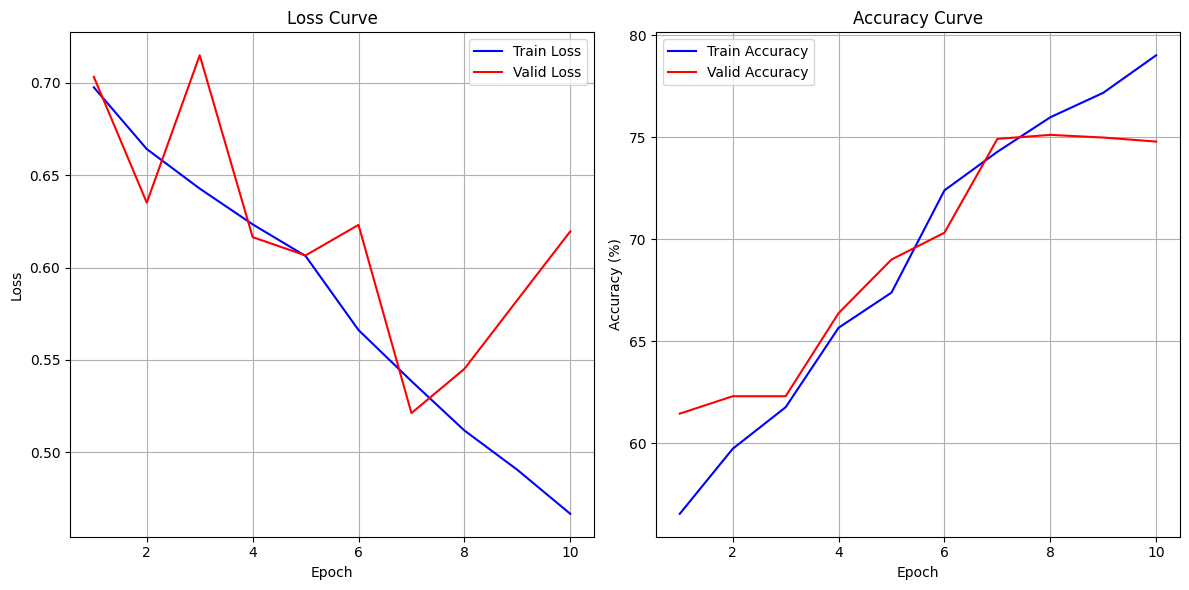

In [ ]:
import matplotlib.pyplot as plt
train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []

valid_data = TensorDataset(torch.tensor(x_valid_ids), torch.tensor(x_valid_attention), torch.tensor(y_valid))
valid_dataloader = DataLoader(valid_data, batch_size=32, shuffle=False)

model = Transformer(vocab_size=30000, d_model=512, num_heads=8, d_ff=2048, num_layers=8, max_len=max_lengths).to(device)

criterion = nn.BCELoss().to(device) 
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)  

num_epochs = 10                                                               

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch
        
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad() 
        
        outputs = model(input_ids)  
        
        loss = criterion(outputs.squeeze(), labels.float()) 
        loss.backward()  
        optimizer.step()  
        
        running_loss += loss.item()
        
        predicted = (outputs.squeeze() > 0.5).float()
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

    train_loss = running_loss / len(train_dataloader)
    train_accuracy = (correct_preds / total_preds) * 100  

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    valid_loss = 0.0
    correct_valid_preds = 0
    total_valid_preds = 0

    with torch.no_grad():
        for batch in valid_dataloader:
            input_ids, attention_mask, labels = batch
            
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)
            
            outputs = model(input_ids)  
            loss = criterion(outputs.squeeze(), labels.float()) 
            valid_loss += loss.item()

            predicted = (outputs.squeeze() > 0.5).float()
            correct_valid_preds += (predicted == labels).sum().item()
            total_valid_preds += labels.size(0)

    epoch_valid_loss = valid_loss / len(valid_dataloader)
    valid_accuracy = (correct_valid_preds / total_valid_preds) * 100  

    valid_losses.append(epoch_valid_loss)
    valid_accuracies.append(valid_accuracy)

    scheduler.step()

    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"  Valid Loss: {epoch_valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.2f}%\n")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", color='blue')
plt.plot(range(1, num_epochs + 1), valid_losses, label="Valid Loss", color='red')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label="Valid Accuracy", color='red')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [52]:
x_test_data = input_x("test.csv")
x_test_data = [" ".join(row) for row in x_test_data]
max_lengths = max([len(sentence) for sentence in x_test_data])
x_test_tokens = tokenizer(x_test_data, padding="max_length", truncation=True, max_length=max_lengths, return_tensors="np")


test_data = TensorDataset(torch.tensor(x_test_tokens["input_ids"]), torch.tensor(x_test_tokens["attention_mask"]))
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

In [ ]:
model.eval()  

all_preds = [] 

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask = batch 
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        
        outputs = model(input_ids)  
        preds = (outputs.squeeze() >= 0.5).float() 
        
        all_preds.append(preds.cpu()) 

all_preds = torch.cat(all_preds, dim=0)

print(f"Predictions: {all_preds}")

Predictions: tensor([0., 0., 0.,  ..., 1., 0., 0.])


In [54]:
print(len(all_preds))
print(len(x_test_data))
def find_id(filename):
    x_data = []
    with open(filename, 'r', encoding="utf-8") as file:
        reader = csv.reader(file)
        next(reader)
        for row in reader:
            x_data.append(row[0])
    return x_data
x_test_id = find_id("test.csv")
print(len(x_test_id))
print(x_test_id[3262])

3263
3263
3263
10875


In [55]:
all_preds = all_preds.numpy().astype(int)

In [56]:
with open('submission.csv', 'w',encoding="utf-8" , newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["id","target"])
    for i in range(len(all_preds)):
        writer.writerow([x_test_id[i]] + [all_preds[i]])

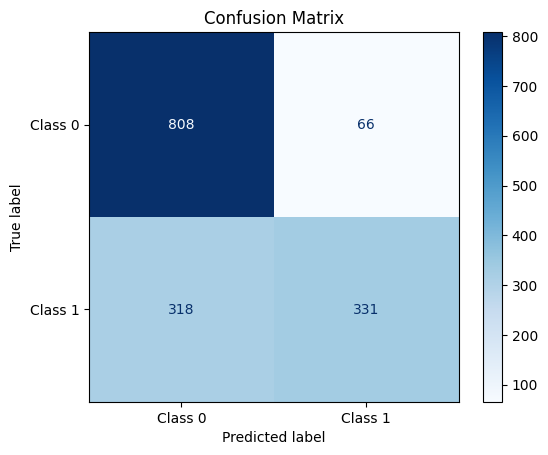

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

valid_data = TensorDataset(torch.tensor(x_valid_ids), torch.tensor(x_valid_attention))
valid_dataloader = DataLoader(valid_data, batch_size=32, shuffle=False)


model.eval() 

y_pred = [] 

with torch.no_grad():  
    for batch in valid_dataloader:
        input_ids, attention_mask = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        
        outputs = model(input_ids)  
        preds = (outputs.squeeze() >= 0.5).float() 
        
        y_pred.append(preds.cpu())  

y_pred = torch.cat(y_pred, dim=0)
cm = confusion_matrix(y_valid, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

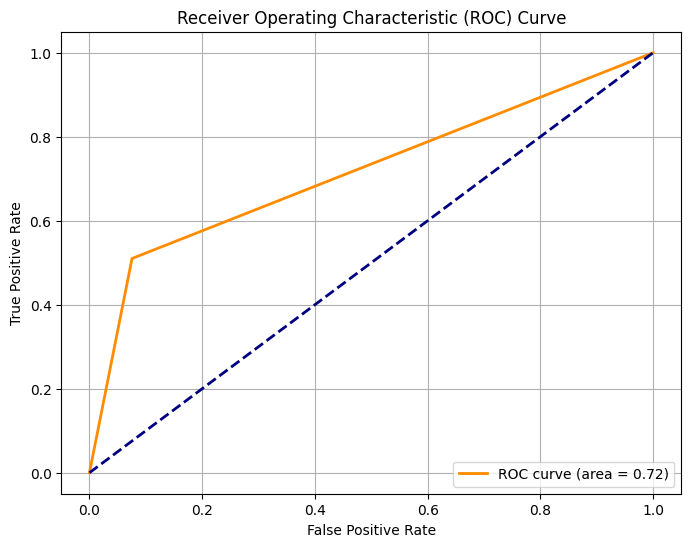

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_valid, y_pred)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()